<a href="https://colab.research.google.com/github/TAEWOOYOON/SkillTreePython-DeepLearning/blob/main/04.Paper-with-code/CGAN/cgan_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CGAN

## 모델 생성

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers, utils
from tensorflow.keras import backend as K

class BuildModel():
  def __init__(self, img_shape, z_dim, label_dim):
    self.img_shape = img_shape
    self.z_dim = z_dim
    self.label_dim = label_dim

  def build_generator(self, 
                 activation = 'selu',
                 last_activation='sigmoid',
                 kernel_size=5):

    h, w, ch = self.img_shape
    
    z = layers.Input(shape=[self.z_dim,], name='noise')
    c = layers.Input(shape=[self.label_dim,], name='condition')
    y = layers.concatenate([z, c])

    y = layers.Dense(int(w/4)*int(h/4)*128)(y)
    y = layers.Reshape( [int(w/4),int(h/4),128] )(y)
    y = layers.BatchNormalization()(y)
    y = layers.Conv2DTranspose(64, kernel_size=5, padding='same', strides=2, activation=activation)(y)
    y = layers.BatchNormalization()(y)
    y = layers.Conv2DTranspose(ch, kernel_size=5, padding='same', strides=2, activation=last_activation)(y)
    
    return models.Model([z, c], y, name='Generator')

  def build_discriminator(self,
                 activation='relu',
                 last_activation='sigmoid',
                 kernel_size=5):

    h, w, ch = self.img_shape
    def _expand_label_input(x):
      y = K.expand_dims(x, axis=1)
      y = K.expand_dims(y, axis=1)
      y = K.tile(y, [1, h, w, 1])
      return y

    x = layers.Input(shape=self.img_shape, name='image')
    c = layers.Input(shape= self.label_dim, name='condition')
    c = layers.Lambda(_expand_label_input)(c)
    
    y = layers.concatenate([x, c], axis=3)
    y = layers.Conv2D(64, kernel_size=kernel_size, strides=2, padding='same', activation=activation)(y)
    y = layers.Dropout(.5)(y)
    y = layers.Conv2D(128, kernel_size=kernel_size, strides=2, padding='same', activation=activation)(y)
    y = layers.Dropout(.5)(y)
    y = layers.Flatten()(y)

    y = layers.Dense(1, activation=last_activation)(y)
    return models.Model([x,c], y, name='Discriminator')

## 데이터 로더

In [ ]:
import tensorflow as tf
import numpy as np

def mnist_loader(standard=False):
  (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
  x_train = np.expand_dims(x_train, 3)
  
  x_train = x_train / 255. # 0~1
  x_test = x_test / 255. # 0~1
  if standard:
    x_train = (x_train*2)-1
    x_test = (x_test*2)-1

  return x_train, y_train, x_test, y_test

def fmnist_loader(standard=False):
  (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
  x_train = np.expand_dims(x_train, 3)

  x_train = x_train / 255.
  x_test = x_test / 255.
  if standard:
    x_train = (x_train*2)-1
    x_test = (x_test*2)-1

  return x_train, y_train, x_test, y_test

def cifar10_loader(standard=False):
  (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

  x_train = x_train / 255.
  x_test = x_test / 255.
  if standard:
    x_train = (x_train*2)-1
    x_test = (x_test*2)-1

  return x_train, y_train, x_test, y_test

## 데이터 시각화

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def display_sample_img(samples, grid, standard=False, size=1):
  h, w = grid
  n = np.cumprod(grid)[-1]
  plt.figure(figsize=(w*size,h*size))
  for i, sample in enumerate(samples[:n]):
    if i==n: break
    if standard:
      sample = ( sample  + 1. ) / 2.
    sample = np.clip(sample, 0, 1)
    plt.subplot(h,w,i+1)
    if sample.shape[-1]==1: plt.imshow(sample[:,:,0], cmap='gray_r')
    else: plt.imshow(sample)
    plt.xticks([]);plt.yticks([])
  plt.show()

11501568/11490434 [==============================] - 0s 0us/step


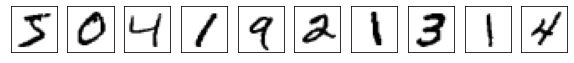

In [ ]:
x_train,_,_,_ = mnist_loader()
display_sample_img(x_train[:10], (10,10))

## CGAN

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers, utils
from utils import display_sample_img

class CGAN():
  def __init__(self, gene, disc, img_shape, noise_dims):
    self.name = 'GAN'
    self.gene = gene
    self.disc = disc
    self.img_shape = img_shape
    self.noise_dims = noise_dims

  def compile(self, 
              loss = 'binary_crossentropy',
              optimizer = 'adam'):
    
    self.disc.compile(loss = loss, optimizer = optimizer)
    self.disc.trainable = False
    
    input_noise = layers.Input(shape=self.noise_dims)
    fake_img = self.gene(input_noise)
    logit = self.disc(fake_img)

    self.gan = models.Model(input_noise, logit, name=self.name)
    self.gan.compile(loss = loss, optimizer = optimizer)

  def _make_datasets(self, x_data):
      dataset = tf.data.Dataset.from_tensor_slices(x_data).shuffle(1)
      dataset = dataset.batch(self.batch_size, drop_remainder=True).prefetch(1)
      return dataset

  def _make_constants(self):
      zeros = tf.constant([0.], shape=[self.batch_size, 1])
      ones = tf.constant([1.], shape=[self.batch_size, 1] )
      return zeros, ones
  
  def _make_random(self):
      return tf.random.normal(shape=[self.batch_size, self.noise_dims])

  def fit(self, 
          x_data, 
          epochs=1,
          batch_size=32,
          standard=False
          ):
    
    # setting
    self.batch_size = batch_size
    train_ds = self._make_datasets(x_data)
    zeros, ones = self._make_constants()
    
    # train
    history = {'d_loss':[], 'g_loss':[]}
    for epoch in range(1, 1+epochs):
      if epoch>1: 
        for h in history: history[h].append(0)

        for real_imgs in train_ds:           
            # phase 1 - training the discriminator
            fake_imgs = self.gene.predict_on_batch(self._make_random())
            
            self.disc.trainable = True
            d_loss_real = self.disc.train_on_batch(real_imgs, ones)
            d_loss_fake = self.disc.train_on_batch(fake_imgs, zeros)
            d_loss = (0.5*d_loss_real) + (0.5*d_loss_fake)
            
            # phase 2 - training the generator
            self.disc.trainable = False
            g_loss = self.gan.train_on_batch(self._make_random() , ones)
            
            history['d_loss'][-1]+=d_loss
            history['g_loss'][-1]+=g_loss
        
        # end 1 epoch        
        print('* epoch: %i, d_loss: %f, g_loss: %f'%( epoch
                                                    , history['d_loss'][-1]
                                                    , history['g_loss'][-1]))
        
      fake_imgs = self.gene.predict(self._make_random())
      display_sample_img(fake_imgs, (2,8), standard=standard, size=2)

In [ ]:
x_train.shape

(60000, 28, 28, 1)

In [ ]:
from gan import GAN

img_shape = (28,28,1)
Z_DIM = 128
builder = BuildModel(img_shape, Z_DIM, label_dim)
gene = builder.build_generator()
disc = builder.build_discriminator()

gene.summary()
disc.summary()

Model: "Generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 noise (InputLayer)             [(None, 128)]        0           []                               
                                                                                                  
 condition (InputLayer)         [(None, 10)]         0           []                               
                                                                                                  
 concatenate_14 (Concatenate)   (None, 138)          0           ['noise[0][0]',                  
                                                                  'condition[0][0]']              
                                                                                                  
 dense_14 (Dense)               (None, 6272)         871808      ['concatenate_14[0][0]'] 